In [1]:
import os
import sys
import numpy as np
import pandas as pd

In [2]:
#Load in your data
Customer_Demo = pd.read_excel('customer_demographics.xlsx', keep_default_na=False, na_values=[""])
Customer_Loan = pd.read_excel('customer_loans.xlsx', keep_default_na=False, na_values=[""])


In [3]:
#Check your data
print(Customer_Demo.head())
print("\n---------------------------------------------------------------------------------------------------")
print(Customer_Loan.head())

     custid              Name                                           Job  \
0  92886957  Barbara Thompson  Automotive Service Technicians and Mechanics   
1  16462625        James Wade                               Prosthodontists   
2  89457436      Joel Jackson                                      Surgeons   
3  68462543    Tyler Clements                       Physicians and Surgeons   
4  63315493     Adam Stephens  Railroad Brake, Signal, and Switch Operators   

   Age       Lat       Long  Income  CreditScore  HouseholdSize  ZipCode  \
0   39  31.84568 -102.36764   43415          658              4    79761   
1   93  42.73920  -84.62081  564164          786              4    48917   
2   99  44.27804  -88.27205  466344          676              1    54140   
3  100  33.50921 -111.89903  756171          694              2    85250   
4   97  33.93113 -117.54866   58948          688              2    92860   

      MajorCity State  MedianHomeValue  MedianHouseholdIncome       

In [4]:
#Create your merged df
Merged_Loan_Data = pd.merge(left=Customer_Demo, right=Customer_Loan, left_on='custid', right_on='custid')

In [5]:
print(Merged_Loan_Data.head())

     custid              Name                                           Job  \
0  92886957  Barbara Thompson  Automotive Service Technicians and Mechanics   
1  16462625        James Wade                               Prosthodontists   
2  89457436      Joel Jackson                                      Surgeons   
3  68462543    Tyler Clements                       Physicians and Surgeons   
4  63315493     Adam Stephens  Railroad Brake, Signal, and Switch Operators   

   Age       Lat       Long  Income_x  CreditScore_x  HouseholdSize  ZipCode  \
0   39  31.84568 -102.36764     43415            658              4    79761   
1   93  42.73920  -84.62081    564164            786              4    48917   
2   99  44.27804  -88.27205    466344            676              1    54140   
3  100  33.50921 -111.89903    756171            694              2    85250   
4   97  33.93113 -117.54866     58948            688              2    92860   

   ... CreditScore_y     Debt_y       Date  

In [6]:
#Now to add in localisation
import geopy # Location to ZIp Code
import surgeo #Zip + Name to race

In [7]:
#Lets start assuming Zip Code and lat long are same
fsg = surgeo.BIFSGModel() #Model taking first and last name, zip  

In [8]:
#Prepare First and last Name as well as title and stuff
from nameparser import HumanName

In [9]:
Merged_Loan_Data["title"] = Merged_Loan_Data["Name"].apply(lambda x: HumanName(x).title)
Merged_Loan_Data["first"] = Merged_Loan_Data["Name"].apply(lambda x: HumanName(x).first)
Merged_Loan_Data["middle"] = Merged_Loan_Data["Name"].apply(lambda x: HumanName(x).middle)
Merged_Loan_Data["last"] = Merged_Loan_Data["Name"].apply(lambda x: HumanName(x).last)
Merged_Loan_Data["suffix"] = Merged_Loan_Data["Name"].apply(lambda x: HumanName(x).suffix)
Merged_Loan_Data["nickname"] = Merged_Loan_Data["Name"].apply(lambda x: HumanName(x).nickname)

In [10]:
Merged_Loan_Data.head()



,custid,Name,Job,Age,Lat,Long,Income_x,CreditScore_x,HouseholdSize,ZipCode,...,HomeValue,LoanAmount,ProductType,LoanStatus,title,first,middle,last,suffix,nickname
0,92886957,Barbara Thompson,Automotive Service Technicians and Mechanics,39,31.84568,-102.36764,43415,658,4,79761,...,179930.0,71972.0,Government_insured,Approved,,Barbara,,Thompson,,
1,16462625,James Wade,Prosthodontists,93,42.73920,-84.62081,564164,786,4,48917,...,386400.0,38640.0,Fixed_rate,Approved,,James,,Wade,,
2,89457436,Joel Jackson,Surgeons,99,44.27804,-88.27205,466344,676,1,54140,...,375840.0,75168.0,Government_insured,Approved,,Joel,,Jackson,,
3,68462543,Tyler Clements,Physicians and Surgeons,100,33.50921,-111.89903,756171,694,2,85250,...,675540.0,67554.0,Government_insured,Approved,,Tyler,,Clements,,
4,63315493,Adam Stephens,"Railroad Brake, Signal, and Switch Operators",97,33.93113,-117.54866,58948,688,2,92860,...,731690.0,146338.0,Government_insured,Approved,,Adam,,Stephens,,


In [11]:
fsg_results = fsg.get_probabilities(Merged_Loan_Data["first"], Merged_Loan_Data["last"], Merged_Loan_Data["ZipCode"])

In [12]:
#df[df.columns.difference(['B', 'D'])]
fsg_results['Max'] = fsg_results[fsg_results.columns.difference(['first_name', 'surname', 'zcta5'])].idxmax(axis=1)


In [13]:
print(fsg_results.head())
fsg_results['first_name'] = fsg_results['first_name'].str.capitalize()
fsg_results['surname'] = fsg_results['surname'].str.capitalize()

   zcta5 first_name   surname     white     black       api    native  \
0  79761    BARBARA  THOMPSON  0.780611  0.191603  0.000039  0.004014   
1  48917      JAMES      WADE  0.833131  0.143230  0.000237  0.001976   
2  54140       JOEL   JACKSON  0.969914  0.012615  0.000100  0.004491   
3  85250      TYLER  CLEMENTS  0.987164  0.000207  0.000058  0.002820   
4  92860       ADAM  STEPHENS  0.963161  0.013266  0.000187  0.001638   

   multiple  hispanic    Max  
0  0.006841  0.016891  white  
1  0.020651  0.000774  white  
2  0.006402  0.006478  white  
3  0.009337  0.000414  white  
4  0.013271  0.008477  white  


In [14]:
fsg_results['zcta5']=fsg_results['zcta5'].astype(int)
print(fsg_results.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48675 entries, 0 to 48674
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   zcta5       48675 non-null  int32  
 1   first_name  48675 non-null  object 
 2   surname     48675 non-null  object 
 3   white       48506 non-null  float64
 4   black       48506 non-null  float64
 5   api         48506 non-null  float64
 6   native      48506 non-null  float64
 7   multiple    48506 non-null  float64
 8   hispanic    48506 non-null  float64
 9   Max         48506 non-null  object 
dtypes: float64(6), int32(1), object(3)
memory usage: 3.5+ MB
None


In [15]:
Merged_Loan_Data_2 = pd.merge(left=Merged_Loan_Data, right=fsg_results, left_on=['first','last','ZipCode'], right_on=['first_name','surname','zcta5'])

In [16]:
Merged_Loan_Data_2.head()

,custid,Name,Job,Age,Lat,Long,Income_x,CreditScore_x,HouseholdSize,ZipCode,...,zcta5,first_name,surname,white,black,api,native,multiple,hispanic,Max
0,92886957,Barbara Thompson,Automotive Service Technicians and Mechanics,39,31.84568,-102.36764,43415,658,4,79761,...,79761,Barbara,Thompson,0.780611,0.191603,0.000039,0.004014,0.006841,0.016891,white
1,16462625,James Wade,Prosthodontists,93,42.73920,-84.62081,564164,786,4,48917,...,48917,James,Wade,0.833131,0.143230,0.000237,0.001976,0.020651,0.000774,white
2,89457436,Joel Jackson,Surgeons,99,44.27804,-88.27205,466344,676,1,54140,...,54140,Joel,Jackson,0.969914,0.012615,0.000100,0.004491,0.006402,0.006478,white
3,68462543,Tyler Clements,Physicians and Surgeons,100,33.50921,-111.89903,756171,694,2,85250,...,85250,Tyler,Clements,0.987164,0.000207,0.000058,0.002820,0.009337,0.000414,white
4,63315493,Adam Stephens,"Railroad Brake, Signal, and Switch Operators",97,33.93113,-117.54866,58948,688,2,92860,...,92860,Adam,Stephens,0.963161,0.013266,0.000187,0.001638,0.013271,0.008477,white


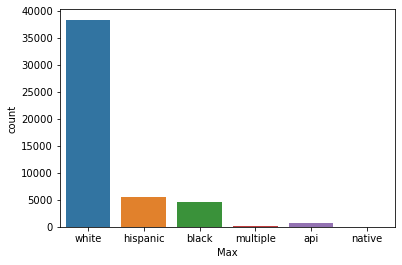

In [17]:
import seaborn as sns
sns.countplot(Merged_Loan_Data_2['Max'],label="Count")

In [18]:
import gender_guesser.detector as gender

In [24]:
d = gender.Detector()
print(d.get_gender(u"Alex"))
Merged_Loan_Data_2["Gender"] = Merged_Loan_Data_2["first_name"].apply(lambda x: d.get_gender(x))

male


In [25]:
Merged_Loan_Data_2.head()

,custid,Name,Job,Age,Lat,Long,Income_x,CreditScore_x,HouseholdSize,ZipCode,...,first_name,surname,white,black,api,native,multiple,hispanic,Max,Gender
0,92886957,Barbara Thompson,Automotive Service Technicians and Mechanics,39,31.84568,-102.36764,43415,658,4,79761,...,Barbara,Thompson,0.780611,0.191603,0.000039,0.004014,0.006841,0.016891,white,female
1,16462625,James Wade,Prosthodontists,93,42.73920,-84.62081,564164,786,4,48917,...,James,Wade,0.833131,0.143230,0.000237,0.001976,0.020651,0.000774,white,male
2,89457436,Joel Jackson,Surgeons,99,44.27804,-88.27205,466344,676,1,54140,...,Joel,Jackson,0.969914,0.012615,0.000100,0.004491,0.006402,0.006478,white,male
3,68462543,Tyler Clements,Physicians and Surgeons,100,33.50921,-111.89903,756171,694,2,85250,...,Tyler,Clements,0.987164,0.000207,0.000058,0.002820,0.009337,0.000414,white,mostly_male
4,63315493,Adam Stephens,"Railroad Brake, Signal, and Switch Operators",97,33.93113,-117.54866,58948,688,2,92860,...,Adam,Stephens,0.963161,0.013266,0.000187,0.001638,0.013271,0.008477,white,male


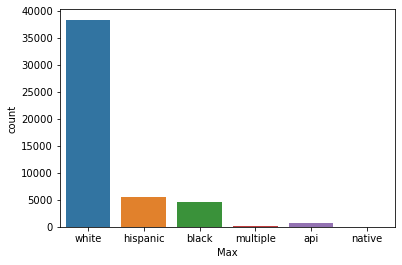

In [102]:
sns.countplot(Merged_Loan_Data_2['Max'],label="Count")

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc2 = OneHotEncoder(handle_unknown='ignore')


In [107]:
#Merged_Loan_Data_2['LoanStatus'].map({'Approved': '1', 'Rejected': '0'})
feature_names = ['Gender']
X = Merged_Loan_Data_2[feature_names]
y = Merged_Loan_Data_2['LoanStatus'].map({'Approved': '1', 'Rejected': '0'})


enc.fit(X)
OneHotEncoder(handle_unknown='ignore') #ignore not known data
enc.categories_
enc.transform(X)
enc_df = pd.DataFrame(enc.fit_transform(Merged_Loan_Data_2[['Gender']]).toarray())
scaler = MinMaxScaler()

##enc_df.join(pd.DataFrame(scaler.fit_transform(Merged_Loan_Data_2[['Income_x']])))
X = enc_df
X['Income'] = (scaler.fit_transform(Merged_Loan_Data_2[['Income_x']]))


Merged_Loan_Data_2['Max'].fillna('Unknown', inplace=True)
enc2.fit(Merged_Loan_Data_2[['Max']])
enc2.categories_
enc2.transform(Merged_Loan_Data_2[['Max']])
X = pd.concat([pd.DataFrame(enc2.fit_transform(Merged_Loan_Data_2[['Max']]).toarray()),X.reset_index(drop=True)], axis=1)
X

,0,1,2,3,4,5,6,0,1,2,3,4,5,Income
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.035550
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.589573
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.485502
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.793848
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.052076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49380,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.026040
49381,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.363861
49382,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.059808
49383,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.011111


In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [113]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.78
Accuracy of Logistic regression classifier on test set: 0.77


C:\Users\Aman\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [114]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.98
Accuracy of Decision Tree classifier on test set: 0.68


In [115]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.81
Accuracy of K-NN classifier on test set: 0.74


In [116]:
from fairlearn.metrics import MetricFrame

In [ ]:
gm = MetricFrame(accuracy_score, y_true, y_pred, sensitive_features=sex)